# Dim 1 point 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-06 21:50:21.495881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 21:50:21.510187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 21:50:21.514534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [5]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':1, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(0, 800),
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'eval_time_range' : slice(-128, -64),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/P2L/window_1/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [7]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 0.238336 gb into memory.
load took: 13.4071 seconds


In [8]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.0238336 gb into memory.
load took: 3.0482 seconds


## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [9]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [10]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [11]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [12]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (37362, 6)
Input (Xp) batch shape: (37362, 1)
Output (y) batch shape: (37362, 2)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [13]:
num_in = batch_out['X'].shape[-1]
experiment_config['num_inputs'] = num_in
experiment_config['num_inputs']

6

In [14]:
networks = {'model1' : {'shape': [12,12,2]}, 
         'model2' : {'shape': [24,24,2]},
         'model3' : {'shape': [48,48,2]},
         'model4' : {'shape': [96,96,2]}, 
         'model5' : {'shape': [12,12,12,2]},
         'model6' : {'shape': [48,48,48,2]}, 
         'model7' : {'shape': [192,192,2]} 
           }

In [15]:
for model_key in networks.keys():
    
    ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = networks[model_key]['shape']) 
    networks[model_key]['num_params'] = ANN_model.count_parameters()
    regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

    print('Start training: ', model_key)
    regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-2)
    
    networks[model_key]['regress_sys'] = regress_sys

    networks[model_key]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + model_key

    regress_sys.save_checkpoint(networks[model_key]['save_dir'])

Start training:  model1
At epoch 1. Train loss :  21.452177924078864 , Test loss: 17.08190803527832 , Test R2: 0.023814797401428223
Early stopping at epoch 13. No improvement in 10 epochs.
Restored best model with smoothed test loss 10.753568
Start training:  model2
At epoch 1. Train loss :  19.085665702819824 , Test loss: 11.441966247558593 , Test R2: 0.528657865524292
At epoch 21. Train loss :  10.280937607223922 , Test loss: 10.616092681884766 , Test R2: 0.5829144954681397
Early stopping at epoch 21. No improvement in 10 epochs.
Restored best model with smoothed test loss 10.647597
Start training:  model3
At epoch 1. Train loss :  15.082649978431496 , Test loss: 10.895637321472169 , Test R2: 0.5683343768119812
Early stopping at epoch 12. No improvement in 10 epochs.
Restored best model with smoothed test loss 10.710315
Start training:  model4
At epoch 1. Train loss :  13.030082135587126 , Test loss: 10.837966346740723 , Test R2: 0.5779858231544495
Early stopping at epoch 12. No impr

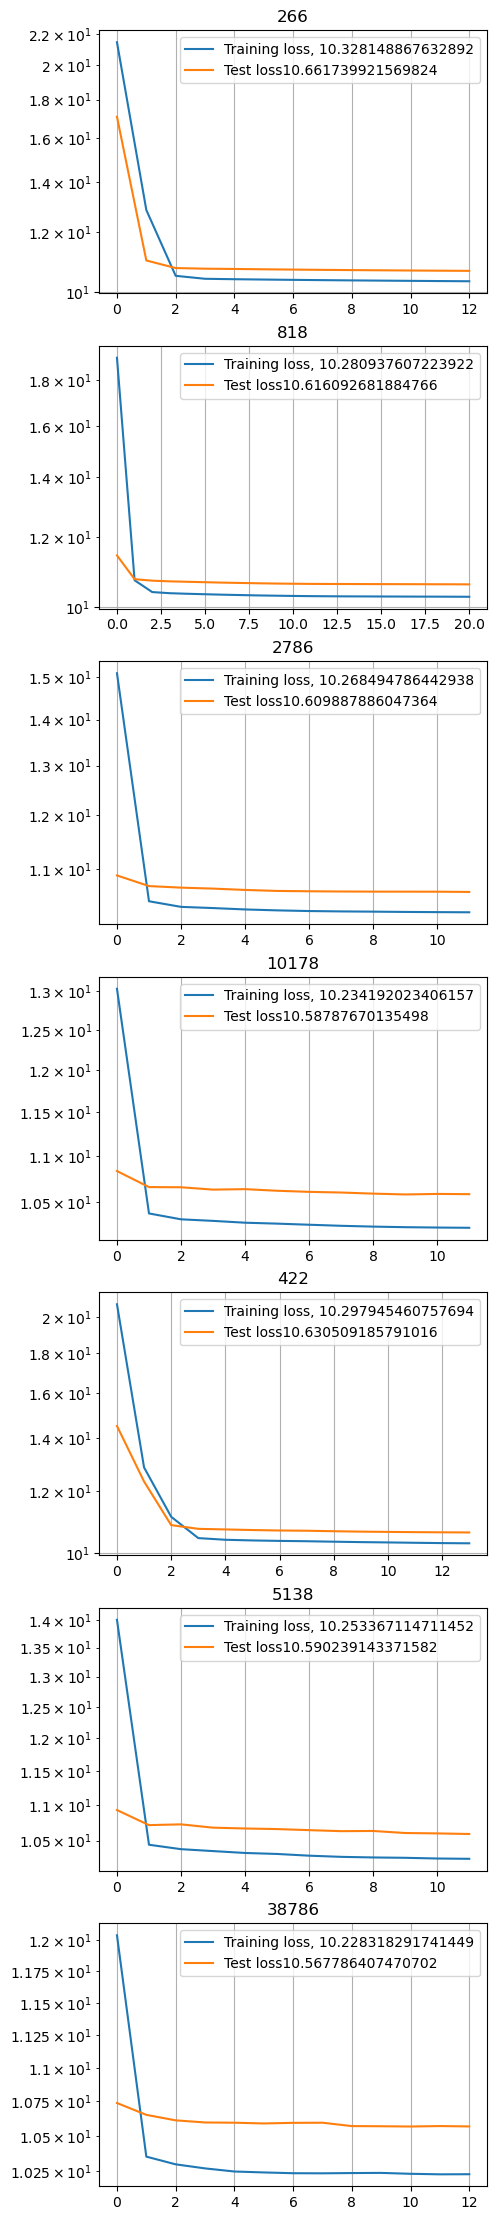

In [16]:
## Loss plot
num_models = len(networks.keys())
fig = plt.figure(figsize=(5, 4*num_models))  

for i, model_key in enumerate(networks.keys()):
    regress_sys = networks[model_key]['regress_sys'] 
    plt.subplot(num_models, 1, i+1)
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.grid()
    plt.yscale('log')
    plt.title(networks[model_key]['regress_sys'].network.count_parameters())
    plt.legend()

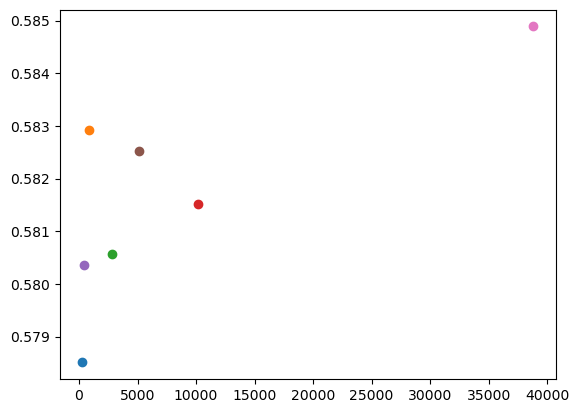

In [17]:
for model_key in networks.keys():
    plt.plot(networks[model_key]['num_params'], 
             networks[model_key]['regress_sys'].test_R2[-1], 'o')

## Evaluation Module

In [20]:
for model_key in networks.keys():
    print(networks[model_key]['save_dir'])
    networks[model_key]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=networks[model_key]['shape'], 
                                 ckpt_dir=networks[model_key]['save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])
    networks[model_key]['eval_sys'].read_ann_regression_model()
    networks[model_key]['eval_sys'].read_eval_data()
    networks[model_key]['eval_sys'].predict()

    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model1
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model2
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model3
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model4
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model5
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model6
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model7


In [42]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])

In [43]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_3_point_stencil'

In [44]:
test_eval.read_ann_regression_model()

In [45]:
test_eval.regress_sys.network.params['params']['layers_0']['kernel']

Array([[ 0.05199946,  0.04341472, -0.12954505, ..., -0.0504831 ,
        -0.09615247, -0.15574235],
       [-0.02738027, -0.05341689, -0.07436807, ..., -0.15101951,
        -0.10539998, -0.2016798 ],
       [ 0.11919633,  0.04156693, -0.0197169 , ..., -0.06562993,
        -0.13040678,  0.13703555],
       ...,
       [-0.15359442,  0.02019267,  0.04149942, ..., -0.06106906,
        -0.1374913 ,  0.10064273],
       [-0.08977871, -0.08219038,  0.03580662, ...,  0.01926511,
         0.01270075, -0.07990777],
       [-0.15255067, -0.00846945,  0.1635101 , ...,  0.06192549,
        -0.08716871,  0.08024892]], dtype=float32)

In [46]:
test_eval.read_eval_data()

In [47]:
test_eval.eval_datatree.ml_dataset['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 64, zl: 2, yh: 108, xh: 100, Xn: 3,
                                      Yn: 3)
    Coordinates:
      * Time                         (Time) object 512B 0019-06-06 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    Dimensions without coordinates: Xn, Yn
    Data variables:
        dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        uphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        vphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        filter_scale                 (yh, xh, Time) float64 6MB dask.array<chunksize=(108, 100, 12), meta=np.ndarray>
        mag_nabla_h_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        mag_nabla_u_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        h_mask                       (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

In [48]:
test_eval.predict()

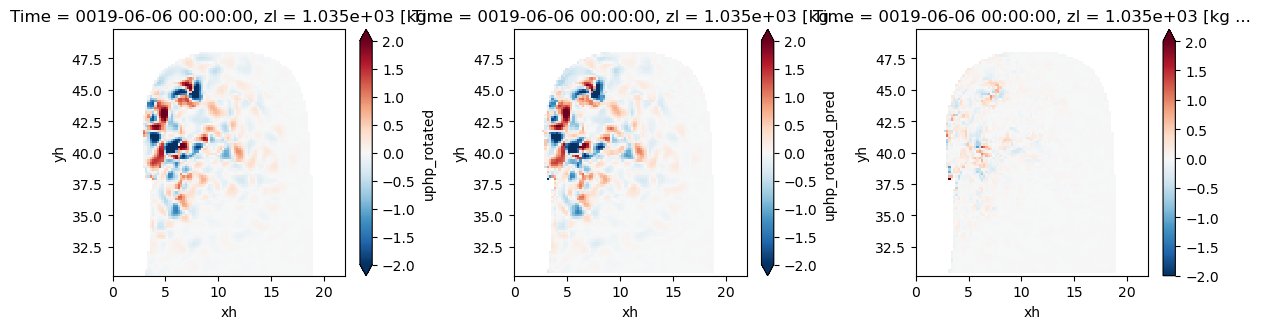

In [49]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 0
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

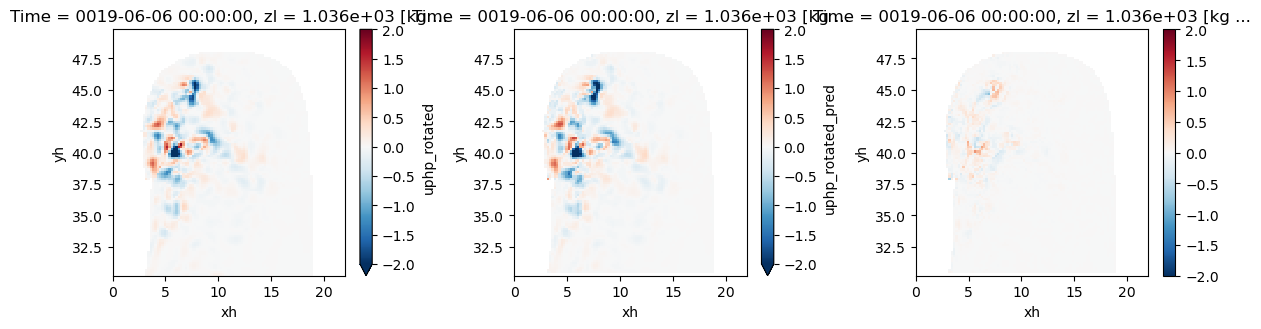

In [50]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 1
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

In [51]:
test_eval.calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval.calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

In [52]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.96899471 0.96783904]
DG 50km, R2 for vphp is (layer:[0,1])[0.98871163 0.97971419]
DG 100km, R2 for uphp is (layer:[0,1])[0.93845672 0.91732043]
DG 100km, R2 for vphp is (layer:[0,1])[0.97573846 0.94922918]
DG 200km, R2 for uphp is (layer:[0,1])[0.80960226 0.68319001]
DG 200km, R2 for vphp is (layer:[0,1])[0.9018091  0.81174887]
DG 400km, R2 for uphp is (layer:[0,1])[0.46186233 0.11655539]
DG 400km, R2 for vphp is (layer:[0,1])[0.79882034 0.34176989]


<Figure size 1200x550 with 0 Axes>

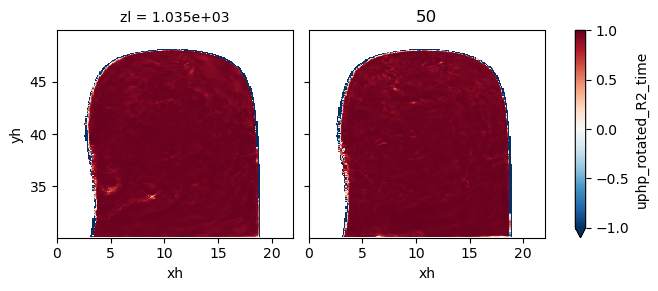

<Figure size 1200x550 with 0 Axes>

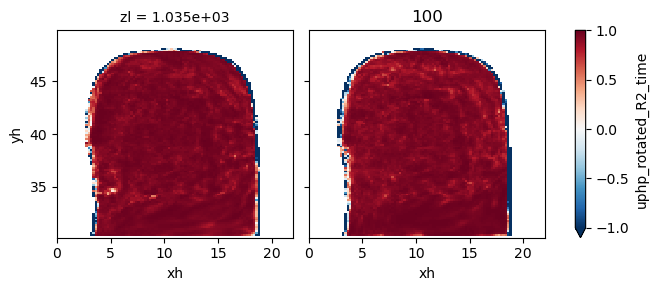

<Figure size 1200x550 with 0 Axes>

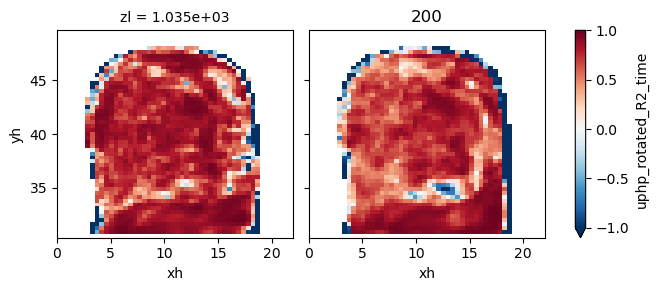

<Figure size 1200x550 with 0 Axes>

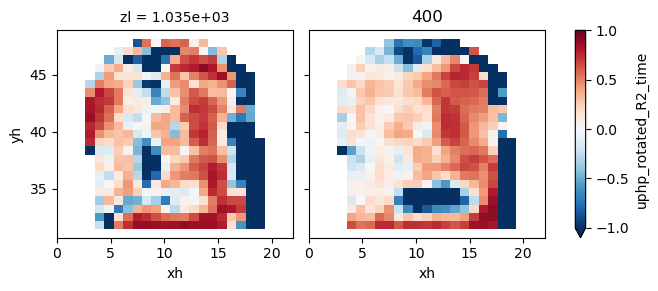

In [53]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

<Figure size 1200x550 with 0 Axes>

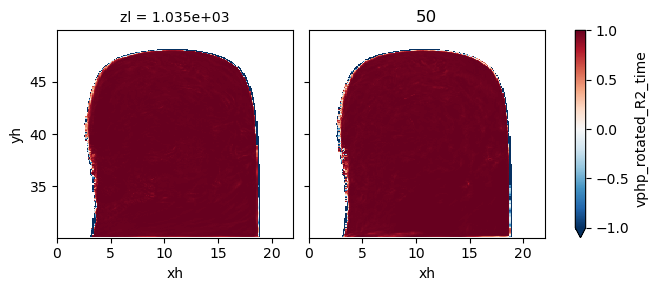

<Figure size 1200x550 with 0 Axes>

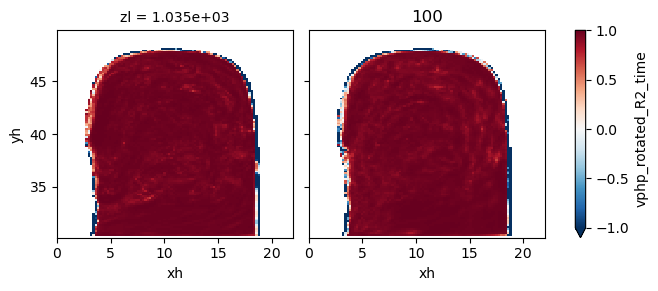

<Figure size 1200x550 with 0 Axes>

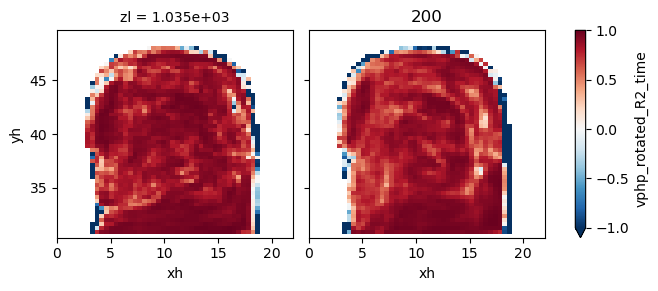

<Figure size 1200x550 with 0 Axes>

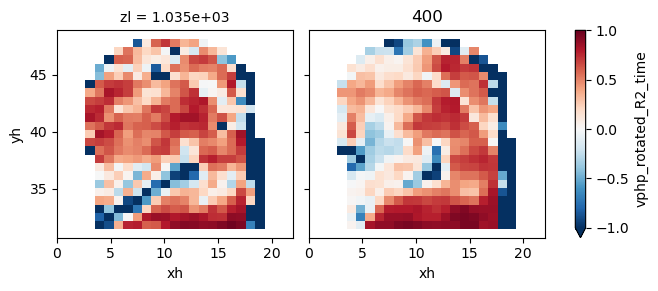

In [54]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)